In [1]:
import math 

import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from autograd_lib import autograd_lib
import torch.nn.functional as F     # Contains all the functions in the torch.nn library
import torchvision.transforms as transforms


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
def train(inputDataLoader,model,loss_function,optimizer,type):
    
    model.train()
    acccs=[]
    loss_array=[]
    for (inputs,label) in inputDataLoader:
        label=label.to(device)
        if type=="MNIST":
            inputs = inputs.reshape(-1, 28*28).to(device)
        else:
            inputs = inputs.reshape(-1,3*32*32).to(device)
        output=model.forward(inputs)
        loss=loss_function(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_array.append(loss.detach().cpu().numpy())
        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = label.detach().cpu().numpy()
        # measure accuracy and record loss
        acc1 = accuracy(preds, labels)
        acccs.append(acc1)
    return np.mean(acccs),np.mean(loss_array)

In [6]:
def test(inputDataLoader,model,loss_function,optimizer,type):
    model.eval()
    output_result=[]
    loss_array=[]
    acccs=[]
    with torch.no_grad():
        for (inputs,label) in inputDataLoader:
            if type=="MNIST":
                inputs = inputs.reshape(-1, 28*28).to(device)
            else:
                inputs = inputs.reshape(-1,3*32*32).to(device)
            label=label.to(device)
            output=model.forward(inputs)
            loss=loss_function(output,label)
            loss_array.append(loss.detach().cpu().numpy())
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = label.detach().cpu().numpy()
            # measure accuracy and record loss
            acc1 = accuracy(preds, labels)
            acccs.append(acc1)
    return np.max(acccs),np.mean(loss_array)

In [7]:
def get_model(input_type,type):
    if type==0:
        return nn.Sequential(
                    nn.Linear(input_type, 202),
                    nn.ReLU(),
                    nn.Linear(202, 10)
            )
    elif type==1:
        return nn.Sequential(

                    nn.Linear(input_type, 500),
                    nn.ReLU(),
                    nn.Linear(500, 100),
                    nn.ReLU(),
                    nn.Linear(100, 10),
                
            )
    elif type==2:
        return nn.Sequential(

                    nn.Linear(input_type, 600),
                    nn.ReLU(),
                    nn.Linear(600, 500),
                    nn.ReLU(),
                    nn.Linear(500, 250),
                    nn.ReLU(),
                    nn.Linear(250, 100),
                    nn.ReLU(),
                    nn.Linear(100, 10)
            )

In [8]:
def initMNIST(batch_size_train,batch_size_test):
    train_dataset= torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

    train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size_train, shuffle=True)
    test_dataset=torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

    test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size_test, shuffle=True)
    return train_loader,test_loader

In [9]:
def initCIFAR10(batch_size_train,batch_size_test):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 4

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train,
                                              shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test,
                                             shuffle=False)

    return trainloader,testloader

In [10]:
parameterList=[0,1,2]
epochs=50
learning_rate=1e-2
batch_size=512

In [11]:
type="MNIST"
training_loss_MNIST=[]
training_acc_MNIST=[]
for parameter in parameterList:
    model=get_model(1*28*28,parameter)
    model.to(device)
    training_loss=[]
    training_accuracy=[]
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    loss_func=nn.CrossEntropyLoss()
    train_loader,test_loader=initMNIST(batch_size,batch_size)
    for epoch in tqdm(range(0,epochs,1)):
        train_acc,train_loss=train(train_loader,model,loss_func,optimizer,type)
        test_acc,test_loss=test(test_loader,model,loss_func,optimizer,type)
        training_loss.append(train_loss)
        training_accuracy.append(train_acc)
    training_loss_MNIST.append(training_loss)
    training_acc_MNIST.append(training_accuracy)

100%|██████████| 50/50 [06:27<00:00,  7.76s/it]


In [12]:
type="CIFAR10"
training_loss_CIFAR10=[]
training_acc_CIFAR10=[]
for parameter in parameterList:
    model=get_model(3*32*32,parameter)
    model.to(device)
    training_loss=[]
    training_accuracy=[]
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    loss_func=nn.CrossEntropyLoss()
    train_loader,test_loader=initCIFAR10(batch_size,batch_size)
    for epoch in tqdm(range(0,epochs,1)):
        train_acc,train_loss=train(train_loader,model,loss_func,optimizer,type)
        test_acc,test_loss=test(test_loader,model,loss_func,optimizer,type)
        training_loss.append(train_loss)
        training_accuracy.append(train_acc)
    training_loss_CIFAR10.append(training_loss)
    training_acc_CIFAR10.append(training_accuracy)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 50/50 [07:53<00:00,  9.46s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 50/50 [07:29<00:00,  9.00s/it]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 50/50 [07:34<00:00,  9.09s/it]


In [13]:
print(training_acc_MNIST)
label_list=["model_number_layer_2","model_number_layer_3","model_number_layer_5"]

[[0.9018692620056498, 0.9657320356638418, 0.9722810734463277, 0.9776935469632769, 0.9797128795903955, 0.981693591101695, 0.984766728460452, 0.9844908633474576, 0.984568105579096, 0.9841046521892655, 0.9880053848870057, 0.9857929466807909, 0.985500529661017, 0.9855115642655367, 0.9885847016242938, 0.986570886299435, 0.9875198622881356, 0.9886784957627118, 0.9899750617937854, 0.9892412605932204, 0.9915419756355932, 0.989064706920904, 0.9863943326271186, 0.9901571327683616, 0.9915971486581922, 0.9903502383474576, 0.9923530190677966, 0.9919668079096045, 0.9917737023305084, 0.9916909427966102, 0.9915364583333333, 0.9921599134887006, 0.9909847281073447, 0.991359904661017, 0.9930592337570621, 0.9932744085451977, 0.9934619968220338, 0.994289592161017, 0.9945213188559322, 0.995166843220339, 0.9946371822033898, 0.9956634004237288, 0.9941516596045198, 0.9939861405367231, 0.9932357874293786, 0.9925019862288136, 0.9940357962570621, 0.9944716631355932, 0.9947530455508474, 0.9955309851694916], [0.895

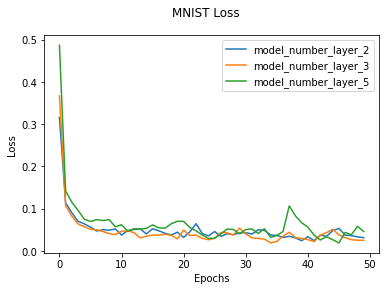

In [23]:
epoch=list(range(0,epochs,1))
fig, ax1 = plt.subplots()
fig.suptitle("MNIST Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

for i,training_loss in enumerate(training_loss_MNIST):
    ax1.plot(epoch,training_loss,label=f"{label_list[i]}")
    ax1.legend()
fig.savefig("part1.2training_loss_MNIST.png")

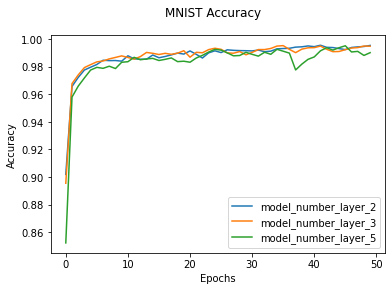

In [22]:
fig, ax1 = plt.subplots()
fig.suptitle("MNIST Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
for i,training_acc in enumerate(training_acc_MNIST):
    ax1.plot(epoch,training_acc,label=f"{label_list[i]}")
    
    ax1.legend()
fig.savefig("part1.2training_acc_MNIST.png")

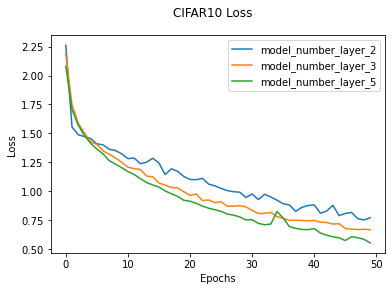

In [20]:
epoch=list(range(0,epochs,1))
fig, ax1 = plt.subplots()
fig.suptitle("CIFAR10 Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
for i,training_loss in enumerate(training_loss_CIFAR10):
    ax1.plot(epoch,training_loss,label=f"{label_list[i]}")
    ax1.legend()
fig.savefig("part1.2training_loss_CIFAR10.png")


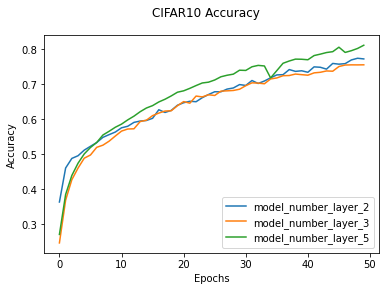

In [19]:

fig, ax1 = plt.subplots()
fig.suptitle("CIFAR10 Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
for i,training_acc in enumerate(training_acc_CIFAR10):
    ax1.plot(epoch,training_acc,label=f"{label_list[i]}")
    ax1.legend()
fig.savefig("part1.2training_acc_CIFAR10.png")